This Notebook contains solution to week 4 exercises of the course [Neuro4ML](https://neuro4ml.github.io/)

- Link to [the exercise notebook](https://github.com/neuro4ml/exercises/blob/main/w4-learning/w4-learning-exercise.ipynb)

- Some additional experiments have been conducted, to observe the effect of different hyperparameters.

- I aimed to employ the same notation as the original papers to ensure clarity and ease of understanding.

- I was not able to reproduce the results of the paper discussing task 3 - correlations. I will update the file if I find a working solution. If you have any idea how to make it work, let me know :)

In [1]:
from brian2 import *
prefs.codegen.target = "numpy"
import copy
from numpy.random import exponential

## Task 2 - Competition and latency

[Song et al. (2000) "Competitive Hebbian learning through spike-timing-dependent synaptic plasticity"](https://www.nature.com/articles/nn0900_919)

- `generate_input` function uses code from [Neuro4ML](https://github.com/neuro4ml/neuro4ml.github.io/blob/main/materials/w4/w4-figures.ipynb) course to produce the input stimuli. It is a little bit different from what has been described in the paper, but it does not effect the final result of the experiment.

- Other than that, the only difference is the parameter `g_max_ex` which in the papre it is equal to 0.015 but in my experiments the excitatory synapses are not 
strong enough to increase the action potential of the postsynaptic neuron to spike, hence the network does not learn anything. By setting the `g_max_ex` equal to 0.04 we can obtain the same results.

In [3]:
def generate_input(N, groupsize, num_repeat, episode_duration):
    start_scope()
    eqs = '''
    starttime : second
    rate = int(t> starttime and t<starttime + 20*ms) * 100*Hz : Hz
    '''
    pre_synapse = NeuronGroup(N, eqs, threshold='rand()<rate*dt')
    pre_synapse.starttime = repeat(rand(N//groupsize)*30, groupsize)*ms
    pre_spike_mon = SpikeMonitor(pre_synapse)

    net = Network(pre_synapse, pre_spike_mon)
    net.run(60*ms)

    first_spike_time = array([pre_spike_mon.spike_trains()[i][0]/ms if len(pre_spike_mon.spike_trains()[i]) != 0 else -10 for i in range(N)])

    spikes_i, spikes_t = pre_spike_mon.i, pre_spike_mon.t
    times_added = [(i)*episode_duration for i in range(num_repeat)]
    time_stack= [spikes_t + t for t in times_added]
    spike_times = np.concatenate(time_stack, axis= 0)* second
    spike_idx = np.tile(spikes_i, reps=num_repeat)
    pre_synapse = SpikeGeneratorGroup(N, spike_idx, spike_times)

    return pre_synapse, first_spike_time, pre_spike_mon

In [4]:
def init_g(N, excitatory_ratio, g_max_ex, g_max_in):
    excitatory_count = int(N * excitatory_ratio)
    inhibitory_count = N - int(N * excitatory_ratio)
    excitatory_idx = np.array([1] * excitatory_count + [0] * inhibitory_count)
    np.random.shuffle(excitatory_idx)

    g_a_init = np.zeros(N)
    g_a_init[excitatory_idx != 0] = g_max_ex * 0.2

    g_max_ex_init = np.zeros(N)
    g_max_ex_init[excitatory_idx != 0] = g_max_ex

    g_max_in_init = np.zeros(N)
    g_max_in_init[excitatory_idx == 0] = g_max_in

    
    return excitatory_idx, g_a_init, g_max_ex_init, g_max_in_init 

In [5]:
def run_experiment(pre_synapse, params, num_repeat, episode_duration):
    N = params['N']
    excitatory_ratio = params['excitatory_ratio']
    ta_m = params['tau_m']
    V_rest = params['V_rest']
    E_ex = params['E_ex']
    tau_ex = params['tau_ex']
    g_max_ex = params['g_max_ex']
    tau_in = params['tau_in']
    E_in = params['E_in']
    g_max_in = params['g_max_in']
    A_pre = params['A_pre']
    tau_pre = params['tau_pre']
    tau_post = params['tau_post']
    A_post = params['A_post']

    
    LIF = '''dV/dt = ( V_rest - V + g_ex * (E_ex - V) + g_in * (E_in - V) ) / tau_m : volt
             d g_ex/dt = - g_ex / tau_ex : 1
             d g_in/dt = - g_in / tau_in : 1
            '''
    post_synapse = NeuronGroup(1, model=LIF, method='euler', threshold=f'V>V_threshold', reset='V=V_reset')
    post_synapse.V = V_rest
    
    synapse_eqs = '''
                g_a : 1
                g_max_ex_ : 1
                g_max_in_ : 1
                dPa/dt = -Pa/tau_pre : 1 (event-driven)
                dM/dt = -M/tau_post : 1 (event-driven)
                '''
    S = Synapses(pre_synapse, post_synapse,
                model=synapse_eqs,
                on_pre = '''
                    g_ex += g_a
                    g_in += g_max_in_
                    Pa += A_pre
                    g_a = clip(g_a + M * g_max_ex_, 0, g_max_ex_)
                    ''',
                on_post = '''
                    M += A_post
                    g_a = clip(g_a + Pa * g_max_ex_ , 0, g_max_ex_ )
                    ''',
                method='exact')
    S.connect()
    
    excitatory_idx, S.g_a, S.g_max_ex_, S.g_max_in_ = init_g(N, excitatory_ratio, g_max_ex, g_max_in)

    pre_spike_mon = SpikeMonitor(pre_synapse)
    post_spike_mon = SpikeMonitor(post_synapse)
    post_state_mon = StateMonitor(post_synapse, 'V', record=True)

    net = Network(pre_synapse, post_synapse, S, pre_spike_mon, post_spike_mon, post_state_mon,)
    net.run(episode_duration * num_repeat)

    return (pre_spike_mon, post_spike_mon), S, post_state_mon, excitatory_idx

In [6]:
def plot_experiment(file_name, display, params):
    g_max_ex = params['g_max_ex']
    g_max_in = params['g_max_in']
    A_pre = params['A_pre']
    A_post = params['A_post']
    
    
    episode_span = int(episode_duration/ms*10)
    num_spikes_last_episode = len(post_spike_mon.t[post_spike_mon.t/ms > post_state_mon.t[-episode_span]/ms])
    num_spikes_first_episode = len(post_spike_mon.t[post_spike_mon.t/ms < post_state_mon.t[episode_span]/ms])
    description =  f'''num_repeat={num_repeat}, g_max_ex={g_max_ex}, g_max_in={g_max_in}, taupre=taupost={tau_pre}, A_pre={A_pre:.5f}, A_post={A_post:.5f}
B = {B}, number of spikes during first episode = {num_spikes_first_episode}, number of spikes during last episode = {num_spikes_last_episode}'''

    f, ((a0, a1), (a2, a3)) = plt.subplots(2, 2, figsize=(9, 6), height_ratios=[0.7, 0.3])

    only_excitatory = np.where(excitatory_idx != 0)[0]
    
    a0.plot(input_stimuli_monitor.t/ms, input_stimuli_monitor.i, '.k')
    a0.set_xlabel('Time (ms)')
    a0.set_ylabel('Neuron index')
    a0.set_title('Input stimuli')

    a1.plot(first_spike_time[only_excitatory], S.g_a[only_excitatory]/g_max_ex , '.k')
    a1.set_xlabel('First spike time [relative latency] (ms)')
    a1.set_ylabel(r'g / $g_{max}$')
    a1.set_title(r'g/$g_{max}$ ratio as a function of relative latency')
    a1.set_ylim([-0.1, 1.05])
    a1.set_xlim([-3, None])

    w_init = array([g_max_ex * 0.2] * len(first_spike_time[only_excitatory]))
    a2.plot(first_spike_time[only_excitatory], w_init / g_max_ex, '.k')
    a2.set_xlabel('First spike time [relative latency] (ms)')
    a2.set_ylabel(r'g / $g_max$')
    a2.set_title(r'initial g/$g_{max}$ ratio as a function of relative latency')
    a2.set_ylim([0, 1])
    a2.set_xlim([-3, None])

    a3.plot(S.i[only_excitatory], S.g_a[only_excitatory]/g_max_ex, '.k')
    a3.set_xlabel('Synapse index')
    a3.set_ylabel(r'g / $g_max$')
    a3.set_title(r'final g/$g_{max}$ ratio of each neuron')
    a3.set_ylim([-0.1, 1.05])

    plt.figtext(0.5, 1, description, ha='center', va='top')
    plt.tight_layout(pad=2.5)
    if file_name:
        plt.savefig(file_name)
    if not display:
        plt.close()

In [7]:
N= 1200
excitatory_ratio = 5/6
groupsize= 100 
num_repeat = 90
episode_duration = 70*ms ## by trial 

In [8]:
pre_synapse, first_spike_time, input_stimuli_monitor = generate_input(N, groupsize, num_repeat, episode_duration)

Text(0.5, 1.0, 'Input stimuli')

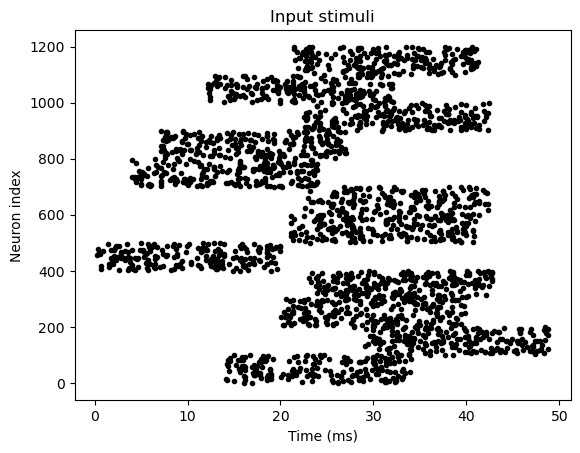

In [9]:
plt.plot(input_stimuli_monitor.t/ms, input_stimuli_monitor.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Input stimuli')

In [10]:
tau_m = 20*ms
V_rest = -70*mV
E_ex = 0*mV
E_in = -70*mV
V_threshold = -54*mV
V_reset = -60*mV

tau_ex = 5*ms
g_max_ex = 0.04 ##  0<= g_a <= g_max_ex
tau_in = 5*ms
g_max_in = 0.05

A_pre = 0.005
tau_pre = 20*ms
tau_post =  20*ms
B = 1.05
A_post = -A_pre*tau_pre*B/tau_post

params = {'N' : N,
        'excitatory_ratio' : excitatory_ratio,
        'tau_m': tau_m,
        'V_rest': V_rest,
        'E_ex' : E_ex,
        'E_in' : E_in,
        'tau_ex' : tau_ex,
        'g_max_ex' : g_max_ex,
        'tau_in' : tau_in,
        'g_max_in' : g_max_in,
        'A_pre' : A_pre,
        'tau_pre' : tau_pre,
        'tau_post' : tau_post,
        'A_post' : A_post,}

In [11]:
pre_synapse_temp = copy.copy(pre_synapse)
(pre_spike_mon, post_spike_mon), S, post_state_mon, excitatory_idx = run_experiment(pre_synapse_temp, params, num_repeat, episode_duration)

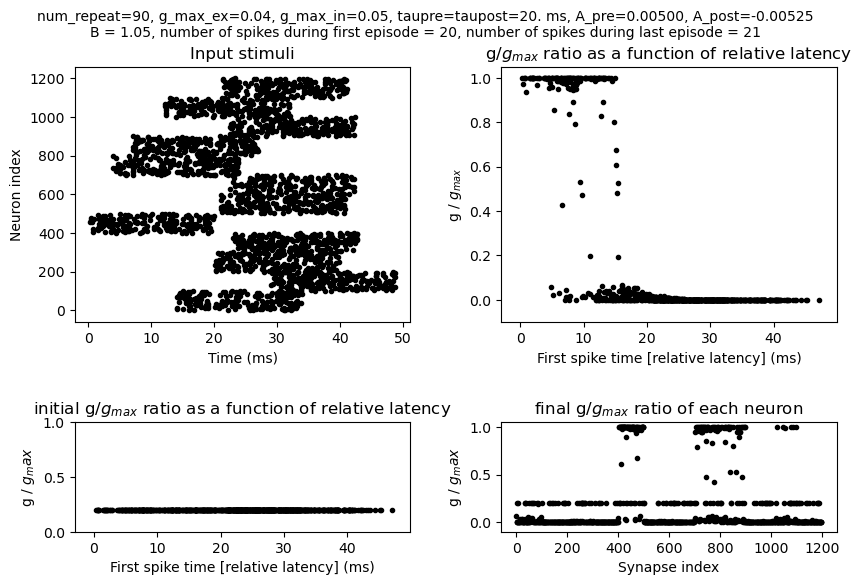

In [15]:
plot_experiment(file_name=None, display=True, params= params)

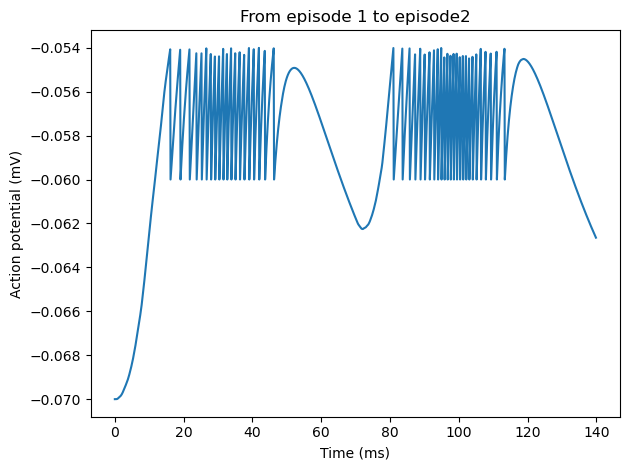

In [16]:
episode_span = int(episode_duration/ms*10)
first_episode_num = 0 
last_episode_num = 2

last_episode_duration = post_state_mon.t[first_episode_num*episode_span:last_episode_num*episode_span]/ms
last_episode_start_time = post_state_mon.t[first_episode_num*episode_span]/ms
last_episode_v = post_state_mon.V[0][first_episode_num*episode_span:last_episode_num*episode_span]

plt.plot(last_episode_duration , last_episode_v) # - last_episode_start_time
plt.xlabel('Time (ms)')
plt.ylabel('Action potential (mV)')
plt.title(f'From episode {first_episode_num+1} to episode{last_episode_num}')
plt.tight_layout()
plt.show()

number of spikes during first episode = 20, number of spikes during last episode = 21


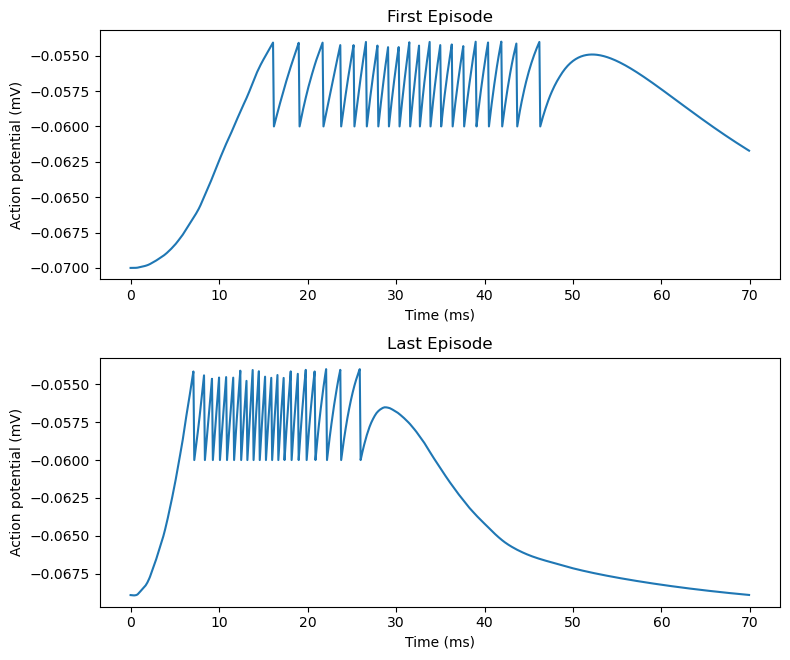

In [17]:
episode_span = int(episode_duration/ms*10) #700
num_episodes = 1

first_episode_duration = post_state_mon.t[:num_episodes*episode_span]/ms
first_episode_v = post_state_mon.V[0][:num_episodes*episode_span]
last_episode_duration = post_state_mon.t[-num_episodes*episode_span:]/ms
last_episode_start_time = post_state_mon.t[-num_episodes*episode_span]/ms
last_episode_v = post_state_mon.V[0][-num_episodes*episode_span:]

num_spikes_last_episode = len(post_spike_mon.t[post_spike_mon.t/ms > post_state_mon.t[-num_episodes*episode_span]/ms])
num_spikes_first_episode = len(post_spike_mon.t[post_spike_mon.t/ms < post_state_mon.t[num_episodes*episode_span]/ms])
print(f'number of spikes during first episode = {num_spikes_first_episode}, number of spikes during last episode = {num_spikes_last_episode}')

fig, axs = plt.subplots(2, 1, figsize=(8, 6.7))

axs[0].plot(first_episode_duration, first_episode_v)
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Action potential (mV)')
axs[0].set_title('First Episode')

axs[1].plot(last_episode_duration - last_episode_start_time, last_episode_v)
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Action potential (mV)')
axs[1].set_title('Last Episode')
plt.tight_layout()
plt.show()

In [18]:
num_short_latency = np.sum(S.g_a/g_max_ex > 0.8)
num_long_latency = np.sum(S.g_a/g_max_ex < 0.1)
num_middle = len(S.g_a) - num_short_latency - num_long_latency
num_short_latency, num_long_latency, num_middle
print(f'''number of strengthened synapses (g/g_max>0.8): {num_short_latency}
number of weakende synapses (g/g_max<0.1): {num_long_latency} 
number of synapses in the middle (0.1<g/g_max<0.8): {num_middle}''')

number of strengthened synapses (g/g_max>0.8): 141
number of weakende synapses (g/g_max<0.1): 918 
number of synapses in the middle (0.1<g/g_max<0.8): 141


### More experiments

In [ ]:
import os

folders_to_check = ["Apre-test", "B-test", "gmax-test", "numrepeat-test"]
for folder_name in folders_to_check:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created.")
    else:
        print(f"Folder '{folder_name}' already exists.")

Folder 'Apre-test' already exists.
Folder 'B-test' already exists.
Folder 'gmax-test' already exists.
Folder 'numrepeat-test' already exists.


In [23]:
N = 1000
excitatory_ratio = 5/6
tau_m = 20*ms
V_rest = -70*mV
E_ex = 0*mV
E_in = -70*mV
tau_ex = 5*ms
g_max_ex = 0.04 ##  0<= g_a <= g_max_ex
tau_in = 5*ms
g_max_in = 0.05
A_pre = 0.005
tau_pre = 20*ms
tau_post =  20*ms
B = 1.05
A_post = -A_pre*tau_pre*B/tau_post

params = {'N' : N,
        'excitatory_ratio' : excitatory_ratio,
        'tau_m': tau_m,
        'V_rest': V_rest,
        'E_ex' : E_ex,
        'E_in' : E_in,
        'tau_ex' : tau_ex,
        'g_max_ex' : g_max_ex,
        'tau_in' : tau_in,
        'g_max_in' : g_max_in,
        'A_pre' : A_pre,
        'tau_pre' : tau_pre,
        'tau_post' : tau_post,
        'A_post' : A_post,}

In [28]:
num_repeat_list = [10, 20, 40, 60, 80, 90, 100]
for i,num_repeat in enumerate(num_repeat_list):
    pre_synapse_temp = copy.copy(pre_synapse)
    (pre_spike_mon, post_spike_mon), S, post_state_mon, excitatory_idx = run_experiment(pre_synapse_temp, params, num_repeat, episode_duration)
    plot_experiment(file_name=f'numrepeat-test/test{i+1}-{num_repeat}.jpg', display=False, params= params)


In [24]:
A_pre_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25]
for i,A_pre in enumerate(A_pre_list):
    params['A_pre'] = A_pre 
    A_post = -A_pre*tau_pre*B/tau_post
    params['A_post'] = A_post
    pre_synapse_temp = copy.copy(pre_synapse)
    (pre_spike_mon, post_spike_mon), S, , excitatory_idx = run_experiment(pre_synapse_temp, params, num_repeat, episode_duration)
    plot_experiment(file_name=f'Apre-test/test{i+1}-{A_pre}.jpg', display=False, params= params)
post_state_mon

In [19]:
g_max_list = [0.015, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.9]
for i,g_max_ex in enumerate(g_max_list):
    params['g_max_ex'] = g_max_ex 
    pre_synapse_temp = copy.copy(pre_synapse)
    (pre_spike_mon, post_spike_mon), S, post_state_mon, excitatory_idx = run_experiment(pre_synapse_temp, params, num_repeat, episode_duration)
    plot_experiment(file_name=f'gmax-test/test{i+1}-{g_max_ex}.jpg', display=False, params= params)


In [18]:
B_list = [0.95, 1, 1.05, 1.1, 1.2, 1.5]
for i,B in enumerate(B_list):
    params['A_pre'] = A_pre
    params['A_post'] = -A_pre*tau_pre*B/tau_post
    pre_synapse_temp = copy.copy(pre_synapse)
    (pre_spike_mon, post_spike_mon), S, post_state_mon, excitatory_idx = run_experiment(pre_synapse_temp, params, num_repeat, episode_duration)
    plot_experiment(file_name=f'B-test/test-{i+1}-{B}.jpg', display=False, params= params)
    

## Task 3 - Correlations

[Song, S, and L F Abbott. “Cortical development and remapping through spike timing-dependent plasticity.” Neuron vol. 32,2 (2001): 339-50. doi:10.1016/s0896-6273(01)00451-2](https://pubmed.ncbi.nlm.nih.gov/11684002/)

In [2]:
N = 1000
tmax = 2000*ms
correlation_time = 20 # (ms)

In [3]:
def generate_input(N, tmax, correlation_time):
    start_scope()
    eqs = '''
    a : 1
    y : 1
    corrgroup = int(i>=500) : 1
    rate_corr = 10*Hz*(1+0.3*a+0.3*y) : Hz
    rate_uncorr = 10*Hz*(1+0.3*sqrt(2)*a) : Hz
    rate = corrgroup*rate_corr+(1-corrgroup)*rate_uncorr : Hz
    '''
    pre_synapse = NeuronGroup(N, eqs, threshold='rand()<rate*dt')
    t = 0*second
    pre_spike_mon = SpikeMonitor(pre_synapse)
    while t < tmax:
        duration = exponential(correlation_time)*ms
        pre_synapse.a = randn(N)
        pre_synapse.y = randn()
        run(duration)
        t += duration

    spike_i, spike_t = pre_spike_mon.i, pre_spike_mon.t
    pre_spike = SpikeGeneratorGroup(N, spike_i, spike_t) 

    return pre_spike, pre_spike_mon

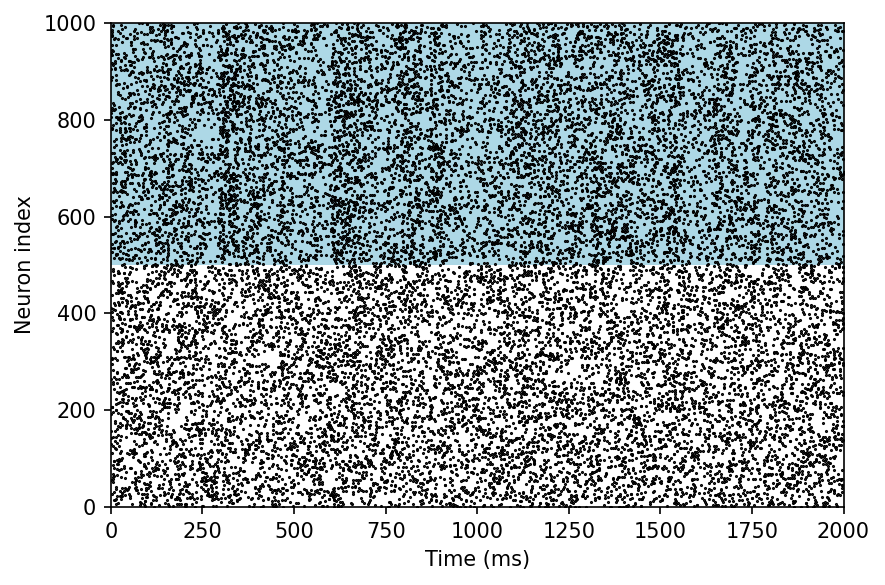

In [4]:
pre_synapse, pre_spike_mon = generate_input(N, tmax, correlation_time)
figure(figsize=(6, 4), dpi=150)
plot(pre_spike_mon.t/ms, pre_spike_mon.i, '.k', ms=1)
fill([0, tmax/ms, tmax/ms, 0], [500, 500, 1000, 1000], 'lightblue')
xlim(0, tmax/ms)
ylim(0, 1000)
xlabel('Time (ms)')
ylabel('Neuron index')
tight_layout();

In [5]:
def correlation_experiment(pre_synapse, params):

    ta_m = params['tau_m']
    V_rest = params['V_rest']
    E_ex = params['E_ex']
    v_threshold = params['V_threshold']
    V_reset = params['V_reset']
    tau_ex = params['tau_ex']
    A_pre = params['A_pre']
    tau_pre = params['tau_pre']
    tau_post = params['tau_post']
    A_post = params['A_post']
    g_max = params['g_max']
    tmax = params['tmax']


    LIF_eqs ='''
    dV/dt = (V_rest - V + g_ex * (E_ex - V)) / tau_m : volt
    dg_ex/dt = -g_ex /tau_ex : 1 
    ''' 
    post_synapse = NeuronGroup(1, model=LIF_eqs, threshold='V>54*(-1)*mV',
                            reset='V=60*(-1)*mV',
                            method='euler')
    post_synapse.V = V_rest

    S = Synapses(pre_synapse,post_synapse,
                        model = '''
                        dapre/dt = -apre/tau_pre :1 (event-driven)
                        dapost/dt = -apost/tau_post :1 (event-driven)
                        g : 1
                        ''',
                        on_pre='''
                        g_ex += g
                        apre += A_pre
                        g = clip(g + apost* g_max, 0, g_max)
                        ''',
                        on_post='''
                        apost += A_post
                        g = clip(g + apre* g_max, 0, g_max)
                        ''',
                        method='exact')
    S.connect()
    S.g = 0.2 * g_max

    pre_spike_mon = SpikeMonitor(pre_synapse)
    post_spike_mon = SpikeMonitor(post_synapse)
    post_state_mon = StateMonitor(post_synapse, 'V', record= True)

    net = Network(pre_synapse, post_synapse, S, post_spike_mon, post_state_mon)
    net.run(tmax)
    return (pre_spike_mon, post_spike_mon), S, post_state_mon

In [6]:
pre_synapse_copy = copy.copy(pre_synapse)
tau_m = 20*ms
V_rest = -74*mV
E_ex = 0*mV
V_threshold = -54*mV
V_reset = -60*mV

tau_ex = 5*ms
A_pre = 0.005
B = 1.05
tau_pre = 20*ms
tau_post = 20*ms
A_post = - B * A_pre * tau_pre / tau_post

g_max = 0.04

params = {'tau_m': tau_m,
          'V_rest': V_rest,
          'E_ex' : E_ex,
          'V_threshold' : V_threshold,
          'V_reset' : V_reset,
          'tau_ex' : tau_ex,
          'A_pre' : A_pre,
          'B' : B,
          'tau_pre' : tau_pre,
          'tau_post' : tau_post,
          'A_post' : A_post,
          'g_max': g_max,
          'tmax': tmax}

(pre_spike_mon, post_spike_mon), S, post_state_mon = correlation_experiment(pre_synapse_copy, params)

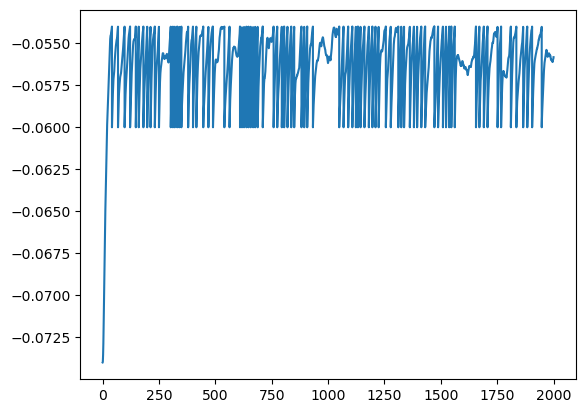

In [7]:
plot(post_state_mon.t/ms, post_state_mon.V[0])

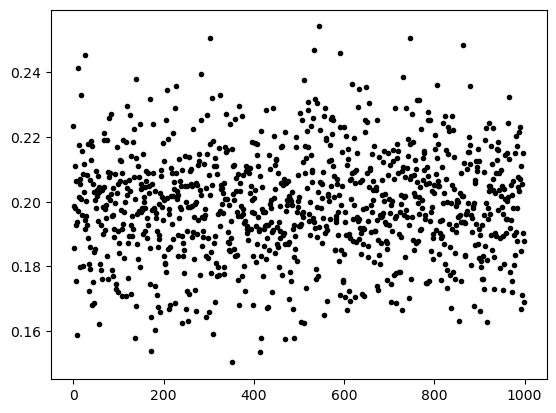

In [8]:
plot(S.i, S.g/g_max, '.k')